In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import graphviz

In [2]:
full_results = pd.read_csv('full_results.csv')
full_stats = pd.read_csv('FullKenPom_pt.csv')

print(full_results.shape)
print(full_stats.shape)

(1112, 11)
(1129, 27)


In [3]:
full_stats.head()

,Unnamed: 0,Season,TeamName,Tempo,AdjTempo,OE,AdjOE,DE,AdjDE,AdjEM,...,O_TO_Pct,D_TO_Pct,D-O_TO_Pct,O_OR_Pct,D_OR_Pct,O-D_OR_Pct,O_FT_Rate,D_FT_Rate,O-D_FT_Rate,LastTenRecord
0,0,2002,Duke,77.0734,73.9016,116.373,121.374,90.2544,87.3522,34.0220,...,18.5699,25.6865,7.1166,34.4605,34.0618,0.3987,41.0140,32.1378,8.8762,0.8
1,1,2002,Cincinnati,68.4368,66.9485,112.274,117.448,86.3924,86.6033,30.8442,...,17.1142,21.2481,4.1339,37.7143,31.3235,6.3908,40.5118,30.3685,10.1433,0.9
2,2,2002,Kansas,79.0371,77.6019,114.544,118.100,94.4261,90.3113,27.7883,...,20.4253,20.6425,0.2172,41.2084,32.5214,8.6870,35.2239,29.4168,5.8071,0.9
3,3,2002,Maryland,75.2758,73.3263,113.167,118.151,94.3706,91.2974,26.8534,...,18.3287,20.5133,2.1846,36.0518,33.5535,2.4983,41.5036,30.9028,10.6008,0.9
4,4,2002,Florida,71.8971,69.5612,110.418,115.387,91.1250,89.6694,25.7176,...,20.5232,25.2218,4.6986,38.4960,33.1315,5.3645,36.1769,34.5721,1.6048,0.6


In [4]:
full_results.head()

,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,0,2002,0,0,First Four,16,77,Alcorn St,Siena,81,16
1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13


In [5]:
###mask test and train data###
res_test_mask = (full_results['Year'] == 2016) | (full_results['Year'] == 2017) | (full_results['Year'] == 2018)
stats_test_mask = (full_stats['Season'] == 2016) | (full_stats['Season'] == 2017) | (full_stats['Season'] == 2018)
res_train_mask = (full_results['Year'] < 2016)
stats_train_mask = (full_stats['Season'] < 2016)

res_data_test = full_results[res_test_mask]
stats_data_test = full_stats[stats_test_mask]
res_data_train = full_results[res_train_mask]
stats_data_train = full_stats[stats_train_mask]

#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

for i in range(len(res_data_test)):
    if res_data_test['Region Name'][i] == "First Four":
        res_data_test = res_data_test.drop(i)
for i in range(len(res_data_train)):
    if res_data_train['Region Name'][i] == "First Four":
        res_data_train = res_data_train.drop(i)
        
#reindex all of them
res_data_test = res_data_test.reset_index()
stats_data_test = stats_data_test.reset_index()
res_data_train = res_data_train.reset_index()
stats_data_train = stats_data_train.reset_index()

res_data_train.head()

#res_data_test.tail()
#stats_data_test.tail()
#res_data_train.tail()
#stats_data_train.tail()


,level_0,index,Unnamed: 0,Year,Round,Region Number,Region Name,SeedA,ScoreA,TeamA,TeamB,ScoreB,SeedB
0,1,1,1,2002,1,1,South,1,84,Duke,Winthrop,37,16
1,2,2,2,2002,1,1,South,2,86,Alabama,Florida Atlantic,78,15
2,3,3,3,2002,1,1,South,3,71,Pittsburgh,Central Connecticut St,54,14
3,4,4,4,2002,1,1,South,4,89,USC,UNC Wilmington,93,13
4,5,5,5,2002,1,1,South,5,75,Indiana,Utah,56,12


In [6]:
#these names match the kenpom stats csv
stats_vec = ["AdjTempo",
            "AdjOE",
            "AdjDE",
            "AdjEM",
            "seed",
            "ConfTournament",
            "SOSAdjEM",
            "NCSOSAdjEM",
            "O-D_eFG_Pct",
            "D-O_TO_Pct",
            "O-D_OR_Pct",
            "O-D_FT_Rate",
            "LastTenRecord"]

print(len(stats_vec))

13


In [7]:
# Move training data into 2 numpy arrays - data and labels (results)
N = len(res_data_train)

training_data = np.zeros((N,13))
training_labels = np.zeros((N,1))

for i in range(len(res_data_train)):
    year = res_data_train['Year'][i]
    teamA = res_data_train['TeamA'][i]
    teamB = res_data_train['TeamB'][i]
    score_diff = res_data_train['ScoreA'][i] - res_data_train['ScoreB'][i]
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_train)):
        if ((stats_data_train['Season'][k] == year) and (stats_data_train['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        training_data[i][s] = stats_data_train[stat][indexA] - stats_data_train[stat][indexB]
    
    if (score_diff > 0):
        training_labels[i][0] = 1
    else:
        training_labels[i][0] = 0

# Move testing data into 2 numpy arrays - data and labels (results)
N = len(res_data_test)

testing_data = np.zeros((N,13))
testing_labels = np.zeros((N,1))

for i in range(len(res_data_test)):
#for i in range(5):
    year = res_data_test['Year'][i]
    teamA = res_data_test['TeamA'][i]
    teamB = res_data_test['TeamB'][i]
    score_diff = res_data_test['ScoreA'][i] - res_data_test['ScoreB'][i]
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamA)):
            indexA = k
            break
            
    for k in range(len(stats_data_test)):
        if ((stats_data_test['Season'][k] == year) and (stats_data_test['TeamName'][k] == teamB)):
            indexB = k
            break
    for s in range(len(stats_vec)):
        stat = stats_vec[s]
        testing_data[i][s] = stats_data_test[stat][indexA] - stats_data_test[stat][indexB]
    
    if (score_diff > 0):
        testing_labels[i][0] = 1
    else:
        testing_labels[i][0] = 0


In [8]:
print(training_data.shape)
print(training_labels.shape)
print('\n')
print(testing_data.shape)
print(testing_labels.shape)
print('\n')
print( training_data )

(882, 13)
(882, 1)


(189, 13)
(189, 1)


[[  8.2874  24.2208 -14.8448 ...  -3.8099   9.5825   0.    ]
 [ -2.0491  15.7256  -7.3805 ...   3.1176  14.1589  -0.1   ]
 [ -0.3923  11.692   -6.6079 ...   0.1097  -7.4804  -0.1   ]
 ...
 [ -3.8929   5.545    9.4537 ...   0.729    1.6018  -0.1   ]
 [  2.7961   8.28    -0.1067 ...  -0.832   22.0564   0.2   ]
 [  7.5601  -2.562    1.6549 ...  -2.7993   2.0688   0.    ]]


In [27]:
#Time to normalize the data
train_data1 = sklearn.preprocessing.normalize( training_data, norm='max', copy=True )
test_data1 = sklearn.preprocessing.normalize( testing_data, norm='max', copy=True )

training_matrix = xgb.DMatrix( train_data1, label=training_labels, feature_names=stats_vec )
test_matrix = xgb.DMatrix( test_data1, label=testing_labels, feature_names=stats_vec )
# training_matrix = xgb.DMatrix( training_data, label=training_labels, feature_names=stats_vec )
# test_matrix = xgb.DMatrix( testing_data, label=testing_labels, feature_names=stats_vec )

evallist = [(test_matrix, 'eval'), (training_matrix, 'train')]

param = {'objective': 'multi:softprob'}
param['eval_metric'] = "merror"
param['num_class'] = 2

In [28]:
bst = xgb.train( param, training_matrix, 500, evallist)

[0]	eval-merror:0.296296	train-merror:0.130385
[1]	eval-merror:0.269841	train-merror:0.096372
[2]	eval-merror:0.280423	train-merror:0.094104
[3]	eval-merror:0.296296	train-merror:0.078231
[4]	eval-merror:0.296296	train-merror:0.068027
[5]	eval-merror:0.301587	train-merror:0.053288
[6]	eval-merror:0.285714	train-merror:0.047619
[7]	eval-merror:0.280423	train-merror:0.040816
[8]	eval-merror:0.285714	train-merror:0.031746
[9]	eval-merror:0.285714	train-merror:0.029478
[10]	eval-merror:0.301587	train-merror:0.022676
[11]	eval-merror:0.296296	train-merror:0.020408
[12]	eval-merror:0.296296	train-merror:0.020408
[13]	eval-merror:0.296296	train-merror:0.019274
[14]	eval-merror:0.296296	train-merror:0.012472
[15]	eval-merror:0.26455	train-merror:0.005669
[16]	eval-merror:0.275132	train-merror:0.005669
[17]	eval-merror:0.26455	train-merror:0.006803
[18]	eval-merror:0.280423	train-merror:0.006803
[19]	eval-merror:0.275132	train-merror:0.005669
[20]	eval-merror:0.280423	train-merror:0.005669
[21]

[193]	eval-merror:0.269841	train-merror:0
[194]	eval-merror:0.269841	train-merror:0
[195]	eval-merror:0.269841	train-merror:0
[196]	eval-merror:0.269841	train-merror:0
[197]	eval-merror:0.269841	train-merror:0
[198]	eval-merror:0.269841	train-merror:0
[199]	eval-merror:0.269841	train-merror:0
[200]	eval-merror:0.269841	train-merror:0
[201]	eval-merror:0.275132	train-merror:0
[202]	eval-merror:0.269841	train-merror:0
[203]	eval-merror:0.275132	train-merror:0
[204]	eval-merror:0.275132	train-merror:0
[205]	eval-merror:0.275132	train-merror:0
[206]	eval-merror:0.275132	train-merror:0
[207]	eval-merror:0.269841	train-merror:0
[208]	eval-merror:0.269841	train-merror:0
[209]	eval-merror:0.269841	train-merror:0
[210]	eval-merror:0.269841	train-merror:0
[211]	eval-merror:0.269841	train-merror:0
[212]	eval-merror:0.269841	train-merror:0
[213]	eval-merror:0.269841	train-merror:0
[214]	eval-merror:0.269841	train-merror:0
[215]	eval-merror:0.269841	train-merror:0
[216]	eval-merror:0.269841	train-m

[389]	eval-merror:0.269841	train-merror:0
[390]	eval-merror:0.269841	train-merror:0
[391]	eval-merror:0.269841	train-merror:0
[392]	eval-merror:0.269841	train-merror:0
[393]	eval-merror:0.269841	train-merror:0
[394]	eval-merror:0.269841	train-merror:0
[395]	eval-merror:0.269841	train-merror:0
[396]	eval-merror:0.269841	train-merror:0
[397]	eval-merror:0.269841	train-merror:0
[398]	eval-merror:0.269841	train-merror:0
[399]	eval-merror:0.269841	train-merror:0
[400]	eval-merror:0.26455	train-merror:0
[401]	eval-merror:0.26455	train-merror:0
[402]	eval-merror:0.269841	train-merror:0
[403]	eval-merror:0.269841	train-merror:0
[404]	eval-merror:0.269841	train-merror:0
[405]	eval-merror:0.269841	train-merror:0
[406]	eval-merror:0.269841	train-merror:0
[407]	eval-merror:0.269841	train-merror:0
[408]	eval-merror:0.269841	train-merror:0
[409]	eval-merror:0.269841	train-merror:0
[410]	eval-merror:0.269841	train-merror:0
[411]	eval-merror:0.269841	train-merror:0
[412]	eval-merror:0.275132	train-mer

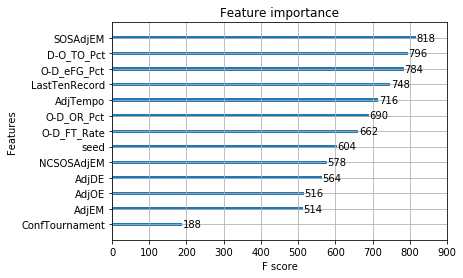

In [29]:
xgb.plot_importance(bst)

In [30]:
ypred = bst.predict(test_matrix)
ypred

array([[2.91143260e-06, 9.99997139e-01],
       [1.25185703e-04, 9.99874830e-01],
       [2.69231829e-03, 9.97307658e-01],
       [6.68703392e-02, 9.33129668e-01],
       [2.11187035e-01, 7.88812995e-01],
       [7.05569284e-03, 9.92944300e-01],
       [7.14682834e-03, 9.92853224e-01],
       [9.99122798e-01, 8.77182349e-04],
       [4.95903369e-05, 9.99950409e-01],
       [2.82742120e-02, 9.71725762e-01],
       [2.03165546e-05, 9.99979734e-01],
       [4.62237865e-01, 5.37762105e-01],
       [1.03749827e-01, 8.96250188e-01],
       [3.67248245e-02, 9.63275194e-01],
       [6.31837233e-04, 9.99368131e-01],
       [4.30395097e-01, 5.69604933e-01],
       [4.59022413e-05, 9.99954104e-01],
       [2.46984797e-04, 9.99753058e-01],
       [7.62518786e-04, 9.99237537e-01],
       [1.89884156e-02, 9.81011510e-01],
       [8.50432320e-04, 9.99149561e-01],
       [1.66425839e-01, 8.33574116e-01],
       [4.85026138e-03, 9.95149791e-01],
       [6.59486473e-01, 3.40513527e-01],
       [8.391645

In [31]:
param = {'objective': 'multi:softprob'}
param['eval_metric'] = "merror"
param['num_class'] = 2

num_round = 1500

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,8)
    for min_child_weight in range(1,6)
]
min_merror = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    # Update Parameters
    param['max_depth'] = max_depth
    param['min_child_weight'] = min_child_weight
    
    #Run CV
    cv_results = xgb.cv(param,
                        training_matrix,
                        num_boost_round=num_round,
                        seed=42,
                        nfold=3,
                        metrics={'merror'},
                        early_stopping_rounds=10)
    
    #Update best MError
    mean_merror = cv_results['test-merror-mean'].min()
    boost_rounds = cv_results['test-merror-mean'].argmin()
    print("\tMerror {} for {} rounds".format(mean_merror, boost_rounds))
    if mean_merror < min_merror:
        min_merror = mean_merror
        best_params = (max_depth, min_child_weight)
    

param['max_depth'] = best_params[0]
param['min_child_weight'] = best_params[1]

CV with max_depth=1, min_child_weight=1
	Merror 0.27437633333333333 for 12 rounds
CV with max_depth=1, min_child_weight=2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.


	Merror 0.27437633333333333 for 12 rounds
CV with max_depth=1, min_child_weight=3
	Merror 0.27437633333333333 for 12 rounds
CV with max_depth=1, min_child_weight=4
	Merror 0.27437633333333333 for 12 rounds
CV with max_depth=1, min_child_weight=5
	Merror 0.2619046666666667 for 29 rounds
CV with max_depth=2, min_child_weight=1
	Merror 0.25963733333333333 for 11 rounds
CV with max_depth=2, min_child_weight=2
	Merror 0.26077100000000003 for 17 rounds
CV with max_depth=2, min_child_weight=3
	Merror 0.26757366666666665 for 13 rounds
CV with max_depth=2, min_child_weight=4
	Merror 0.2698413333333333 for 2 rounds
CV with max_depth=2, min_child_weight=5
	Merror 0.26077066666666665 for 11 rounds
CV with max_depth=3, min_child_weight=1
	Merror 0.264172 for 10 rounds
CV with max_depth=3, min_child_weight=2
	Merror 0.26417266666666667 for 13 rounds
CV with max_depth=3, min_child_weight=3
	Merror 0.2630383333333333 for 8 rounds
CV with max_depth=3, min_child_weight=4
	Merror 0.2641723333333333 for 2

In [38]:
ypred = bst.predict(test_matrix)
correct_list = np.zeros_like(testing_labels)
for i in range(len(ypred)):
    if ypred[i][1] > ypred[i][0]:
        metric = 1 # team A predicted to win
    else:
        metric = 0
    correct_list[i][0] = metric
print("% Correct:", (correct_list.sum() / len(correct_list))*100)

% Correct: 82.53968253968253
